# Emoji Frequency: Bots vs Non-Bots

Analyze emoji usage patterns across datasets to compare bot and human accounts.

In [33]:
import json
import re
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

DATASETS_DIR = Path("datasets")

## Load datasets and classify posts by bot / non-bot

In [34]:
# Regex covering the main Unicode emoji blocks
EMOJI_RE = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "\U0001FA00-\U0001FA6F"  # chess symbols
    "\U0001FA70-\U0001FAFF"  # symbols extended-A
    "\U00002702-\U000027B0"  # dingbats
    "\U0000FE00-\U0000FE0F"  # variation selectors
    "\U0000200D"             # zero-width joiner
    "\U00002600-\U000026FF"  # miscellaneous symbols
    "\U00002B00-\U00002BFF"  # arrows & symbols
    "\U00003030"             # wavy dash (〰️)
    "]+",
    flags=re.UNICODE,
)


# Emoji sequences can be multi-codepoint (flags, skin tones, ZWJ sequences).
# Counting raw codepoints inflates emoji counts and pollutes "top emoji" stats,
# so we split each regex match into proper emoji sequences below.
KEYCAP_RE = re.compile(r"[0-9#*]\ufe0f?\u20e3")  # e.g. 1️⃣, #️⃣, *️⃣
ZWJ = "\u200d"
# Variation selectors (VS1..VS16), used in some emoji sequences (notably FE0E/FE0F).


def _is_regional_indicator(ch: str) -> bool:
    o = ord(ch)
    return 0x1F1E6 <= o <= 0x1F1FF


def _is_skin_tone_modifier(ch: str) -> bool:
    o = ord(ch)
    return 0x1F3FB <= o <= 0x1F3FF


def _is_variation_selector(ch: str) -> bool:
    o = ord(ch)
    return 0xFE00 <= o <= 0xFE0F


def _split_emoji_run(run: str) -> list[str]:
    """Split a run of emoji-related codepoints into emoji sequences."""
    emojis: list[str] = []
    i = 0
    n = len(run)

    while i < n:
        ch = run[i]

        # Skip stray joiners/selectors/modifiers (shouldn't normally start a run).
        if ch == ZWJ or _is_variation_selector(ch) or _is_skin_tone_modifier(ch):
            i += 1
            continue

        # Flags are pairs of regional indicators.
        if _is_regional_indicator(ch) and i + 1 < n and _is_regional_indicator(run[i + 1]):
            emojis.append(run[i : i + 2])
            i += 2
            continue

        # Start a new emoji sequence.
        seq = ch
        i += 1

        # Optional variation selectors immediately after base.
        while i < n and _is_variation_selector(run[i]):
            seq += run[i]
            i += 1

        # Optional skin tone modifier.
        if i < n and _is_skin_tone_modifier(run[i]):
            seq += run[i]
            i += 1
            while i < n and _is_variation_selector(run[i]):
                seq += run[i]
                i += 1

        # ZWJ sequences: (ZWJ + base + modifiers)*.
        while i < n and run[i] == ZWJ:
            seq += run[i]
            i += 1
            if i >= n:
                break

            # Next base.
            seq += run[i]
            i += 1

            while i < n and _is_variation_selector(run[i]):
                seq += run[i]
                i += 1

            if i < n and _is_skin_tone_modifier(run[i]):
                seq += run[i]
                i += 1
                while i < n and _is_variation_selector(run[i]):
                    seq += run[i]
                    i += 1

        emojis.append(seq)

    return emojis


def extract_emojis(text: str) -> list[str]:
    """Extract emojis as *emoji sequences* (not raw codepoints)."""
    out: list[str] = []

    # Keycap emojis (e.g. 1️⃣, #️⃣, *️⃣) are not covered by EMOJI_RE.
    out.extend(KEYCAP_RE.findall(text))

    for run in EMOJI_RE.findall(text):
        out.extend(_split_emoji_run(run))

    return out


# Collect per-user emoji counts and word counts, split by bot / non-bot
bot_emoji_counts_per_user: dict[str, list[int]] = {}   # dataset_id -> [count_per_user]
human_emoji_counts_per_user: dict[str, list[int]] = {}

bot_emoji_per_word: dict[str, list[float]] = {}  # dataset_id -> [emoji/word ratio per user]
human_emoji_per_word: dict[str, list[float]] = {}

bot_post_lengths: dict[str, list[float]] = {}  # dataset_id -> [avg post length per user]
human_post_lengths: dict[str, list[float]] = {}

bot_all_post_lens: list[int] = []   # every individual post length
human_all_post_lens: list[int] = []

bot_mention_counts: dict[str, list[int]] = {}  # dataset_id -> [@ count per user]
human_mention_counts: dict[str, list[int]] = {}

bot_all_emojis: list[str] = []
human_all_emojis: list[str] = []

dataset_ids = sorted(
    int(p.stem.split(".")[-1])
    for p in DATASETS_DIR.glob("dataset.bots.*.txt")
)

for did in dataset_ids:
    # Load bot IDs
    bot_ids = set(
        (DATASETS_DIR / f"dataset.bots.{did}.txt").read_text().strip().splitlines()
    )

    # Load posts
    with open(DATASETS_DIR / f"dataset.posts&users.{did}.json") as f:
        data = json.load(f)

    # Build per-user emoji counts, word counts, post lengths, and @ mentions
    user_emojis: dict[str, list[str]] = {}
    user_word_counts: dict[str, int] = {}
    user_post_lens: dict[str, list[int]] = {}  # author_id -> [len of each post]
    user_mentions: dict[str, int] = {}  # author_id -> total @ mention count
    for post in data["posts"]:
        emojis = extract_emojis(post["text"])
        user_emojis.setdefault(post["author_id"], []).extend(emojis)
        words = len(post["text"].split())
        user_word_counts[post["author_id"]] = user_word_counts.get(post["author_id"], 0) + words
        user_post_lens.setdefault(post["author_id"], []).append(len(post["text"]))
        mentions = len(re.findall(r"@\w+", post["text"]))
        user_mentions[post["author_id"]] = user_mentions.get(post["author_id"], 0) + mentions

    # All user IDs from the users list
    all_user_ids = {u["id"] for u in data["users"]}

    bot_counts = []
    human_counts = []
    bot_ratios = []
    human_ratios = []
    bot_avg_lens = []
    human_avg_lens = []
    bot_ments = []
    human_ments = []
    for uid in all_user_ids:
        emojis = user_emojis.get(uid, [])
        emoji_count = len(emojis)
        word_count = user_word_counts.get(uid, 0)
        ratio = emoji_count / word_count if word_count > 0 else 0.0
        post_lens = user_post_lens.get(uid, [])
        avg_len = np.mean(post_lens) if post_lens else 0.0
        ment_count = user_mentions.get(uid, 0)
        if uid in bot_ids:
            bot_counts.append(emoji_count)
            bot_all_emojis.extend(emojis)
            bot_ratios.append(ratio)
            bot_avg_lens.append(avg_len)
            bot_all_post_lens.extend(post_lens)
            bot_ments.append(ment_count)
        else:
            human_counts.append(emoji_count)
            human_all_emojis.extend(emojis)
            human_ratios.append(ratio)
            human_avg_lens.append(avg_len)
            human_all_post_lens.extend(post_lens)
            human_ments.append(ment_count)

    bot_emoji_counts_per_user[did] = bot_counts
    human_emoji_counts_per_user[did] = human_counts
    bot_emoji_per_word[did] = bot_ratios
    human_emoji_per_word[did] = human_ratios
    bot_post_lengths[did] = bot_avg_lens
    human_post_lengths[did] = human_avg_lens
    bot_mention_counts[did] = bot_ments
    human_mention_counts[did] = human_ments

    print(
        f"Dataset {did}: {len(bot_ids)} bots, {len(all_user_ids) - len(bot_ids)} humans, "
        f"bot emojis={sum(bot_counts)}, human emojis={sum(human_counts)}"
    )

Dataset 30: 66 bots, 209 humans, bot emojis=1686, human emojis=1956
Dataset 31: 27 bots, 144 humans, bot emojis=513, human emojis=1495
Dataset 32: 63 bots, 208 humans, bot emojis=1613, human emojis=2579
Dataset 33: 28 bots, 144 humans, bot emojis=352, human emojis=2008


## Per-user emoji count: mean and standard deviation

In [35]:
# Aggregate across all datasets
all_bot_counts = [c for counts in bot_emoji_counts_per_user.values() for c in counts]
all_human_counts = [c for counts in human_emoji_counts_per_user.values() for c in counts]

bot_arr = np.array(all_bot_counts, dtype=float)
human_arr = np.array(all_human_counts, dtype=float)

print(f"Bots   — users: {len(bot_arr)}, mean emojis/user: {bot_arr.mean():.2f}, std: {bot_arr.std():.2f}")
print(f"Humans — users: {len(human_arr)}, mean emojis/user: {human_arr.mean():.2f}, std: {human_arr.std():.2f}")

Bots   — users: 184, mean emojis/user: 22.63, std: 28.61
Humans — users: 705, mean emojis/user: 11.40, std: 21.19


## Plot 1 — Mean emoji count per user with standard deviation (per dataset)

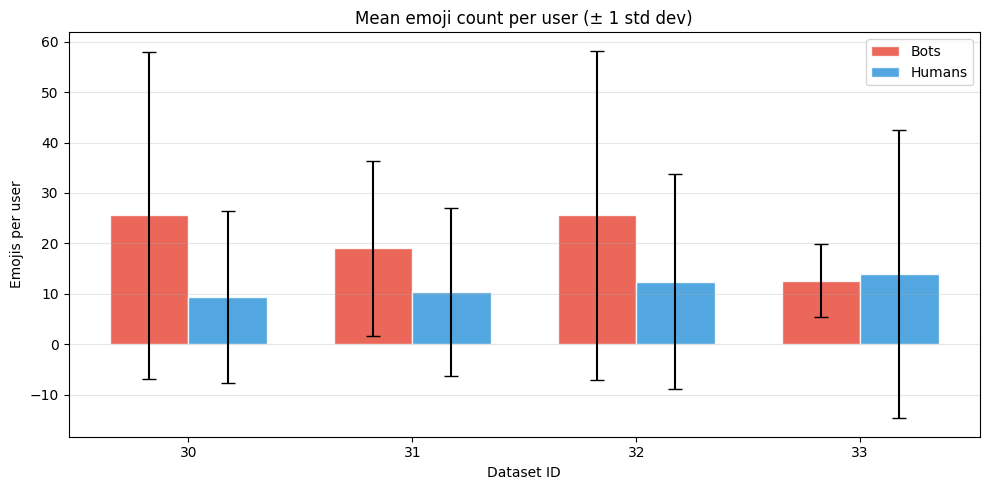

In [36]:
labels = [str(d) for d in dataset_ids]
x = np.arange(len(labels))
width = 0.35

bot_means = [np.mean(bot_emoji_counts_per_user[d]) for d in dataset_ids]
bot_stds = [np.std(bot_emoji_counts_per_user[d]) for d in dataset_ids]
human_means = [np.mean(human_emoji_counts_per_user[d]) for d in dataset_ids]
human_stds = [np.std(human_emoji_counts_per_user[d]) for d in dataset_ids]

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width / 2, bot_means, width, yerr=bot_stds, label="Bots",
               capsize=5, color="#e74c3c", alpha=0.85, edgecolor="white")
bars2 = ax.bar(x + width / 2, human_means, width, yerr=human_stds, label="Humans",
               capsize=5, color="#3498db", alpha=0.85, edgecolor="white")

ax.set_xlabel("Dataset ID")
ax.set_ylabel("Emojis per user")
ax.set_title("Mean emoji count per user (± 1 std dev)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis="y", alpha=0.3)
fig.tight_layout()
plt.show()

## Plot 2 — Aggregated comparison across all datasets

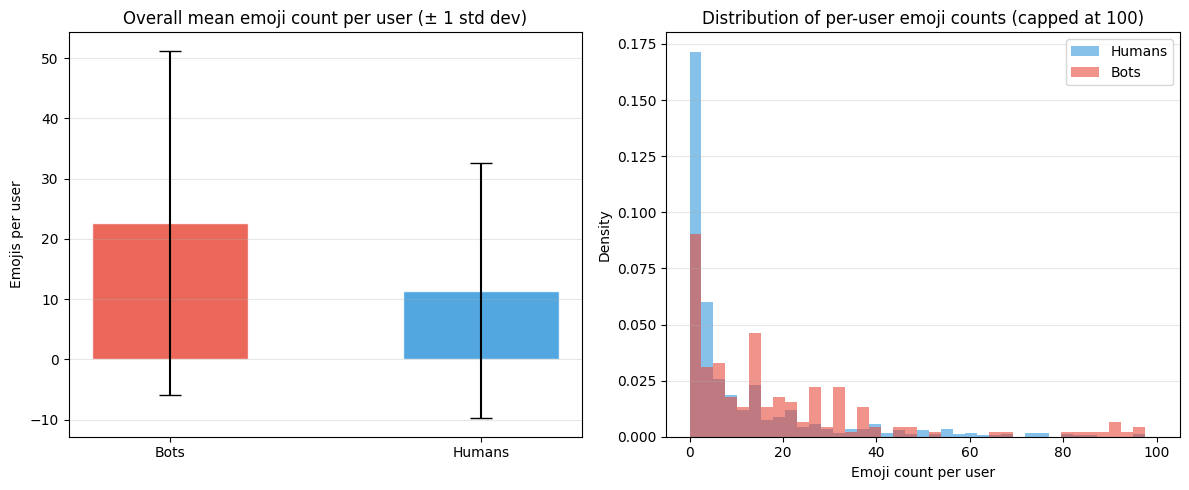

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: bar chart of overall mean ± std ---
categories = ["Bots", "Humans"]
means = [bot_arr.mean(), human_arr.mean()]
stds = [bot_arr.std(), human_arr.std()]
colors = ["#e74c3c", "#3498db"]

axes[0].bar(categories, means, yerr=stds, capsize=8, color=colors, alpha=0.85, edgecolor="white", width=0.5)
axes[0].set_ylabel("Emojis per user")
axes[0].set_title("Overall mean emoji count per user (± 1 std dev)")
axes[0].grid(axis="y", alpha=0.3)

# --- Right: histogram of per-user emoji counts ---
max_val = int(max(bot_arr.max(), human_arr.max()))
cap = 100  # cap x-axis for readability
bins = np.linspace(0, min(max_val, cap), 40)

axes[1].hist(human_arr[human_arr <= cap], bins=bins, alpha=0.6, label="Humans", color="#3498db", density=True)
axes[1].hist(bot_arr[bot_arr <= cap], bins=bins, alpha=0.6, label="Bots", color="#e74c3c", density=True)
axes[1].set_xlabel("Emoji count per user")
axes[1].set_ylabel("Density")
axes[1].set_title(f"Distribution of per-user emoji counts (capped at {cap})")
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

fig.tight_layout()
plt.show()

## Plot 3 — Top emojis used by bots vs humans

/var/folders/qc/spmpblqd0hx_m0l51jtyldtr0000gn/T/ipykernel_47571/1867557014.py:29: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/qc/spmpblqd0hx_m0l51jtyldtr0000gn/T/ipykernel_47571/1867557014.py:29: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/qc/spmpblqd0hx_m0l51jtyldtr0000gn/T/ipykernel_47571/1867557014.py:29: UserWarning: Glyph 129419 (\N{BUTTERFLY}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/qc/spmpblqd0hx_m0l51jtyldtr0000gn/T/ipykernel_47571/1867557014.py:29: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/qc/spmpblqd0hx_m0l51jtyldtr0000gn/T/ipykernel_47571/1867557014.py:29: UserWarning: Glyph 128253 (\N{FILM PROJECTOR}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/qc/spmpblqd0hx_m0l51jtyldtr0000gn/T/ipykernel_47571/18675

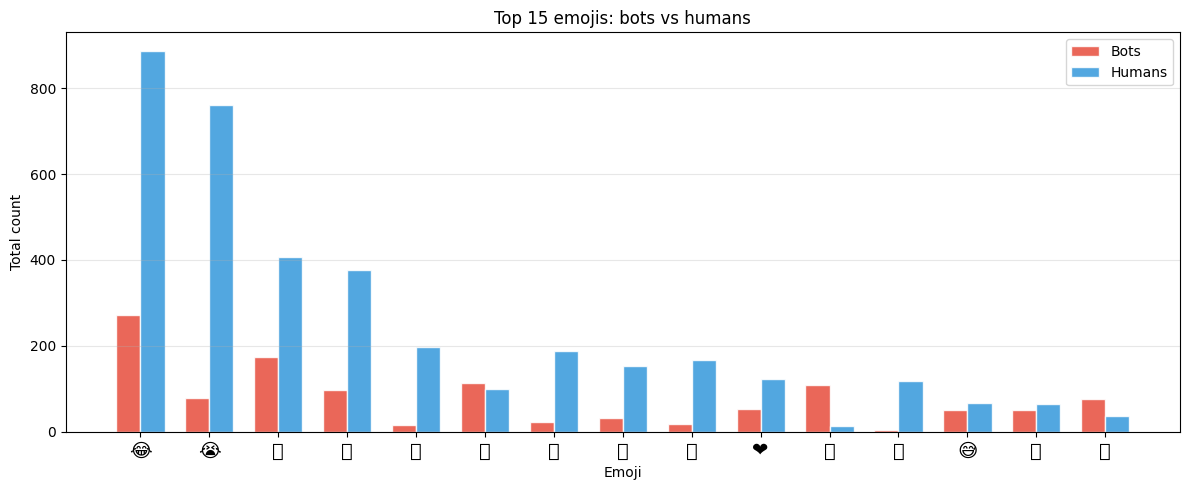

In [38]:
TOP_N = 15

bot_counter = Counter(bot_all_emojis)
human_counter = Counter(human_all_emojis)

# Union of top emojis from both groups
top_emojis = sorted(
    {e for e, _ in bot_counter.most_common(TOP_N)} | {e for e, _ in human_counter.most_common(TOP_N)},
    key=lambda e: bot_counter[e] + human_counter[e],
    reverse=True,
)[:TOP_N]

bot_freqs = [bot_counter[e] for e in top_emojis]
human_freqs = [human_counter[e] for e in top_emojis]

x = np.arange(len(top_emojis))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - width / 2, bot_freqs, width, label="Bots", color="#e74c3c", alpha=0.85, edgecolor="white")
ax.bar(x + width / 2, human_freqs, width, label="Humans", color="#3498db", alpha=0.85, edgecolor="white")
ax.set_xlabel("Emoji")
ax.set_ylabel("Total count")
ax.set_title(f"Top {TOP_N} emojis: bots vs humans")
ax.set_xticks(x)
ax.set_xticklabels(top_emojis, fontsize=14)
ax.legend()
ax.grid(axis="y", alpha=0.3)
fig.tight_layout()
plt.show()

## Plot 4 — Emojis per word count (per dataset and aggregated)

Bots   — mean emojis/word: 0.0296, std: 0.0290
Humans — mean emojis/word: 0.0358, std: 0.0670


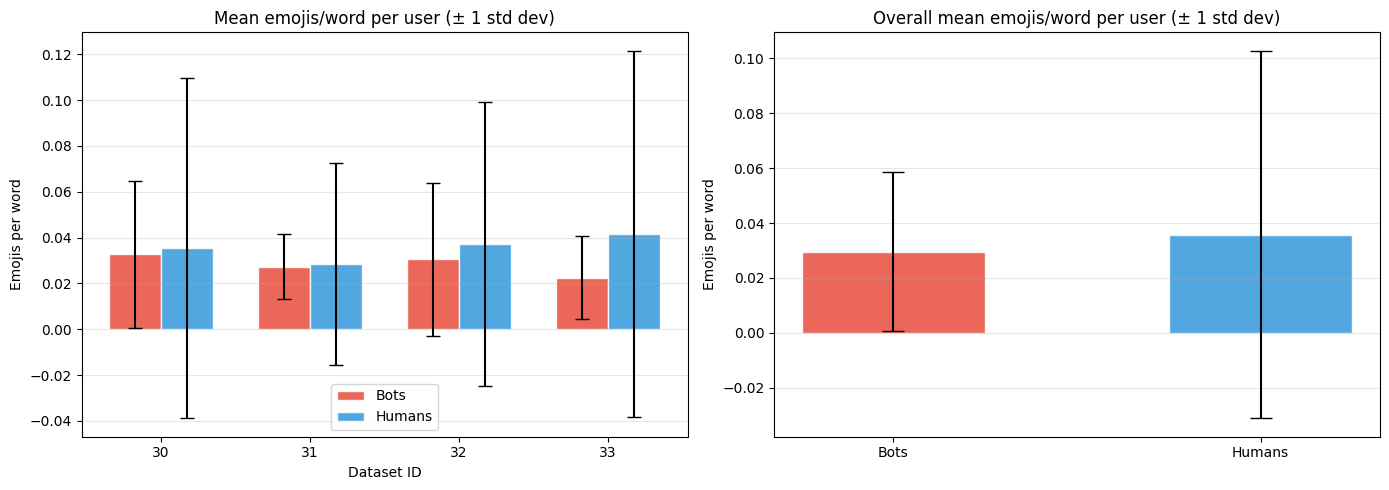

In [39]:
all_bot_ratios = [r for ratios in bot_emoji_per_word.values() for r in ratios]
all_human_ratios = [r for ratios in human_emoji_per_word.values() for r in ratios]

bot_ratio_arr = np.array(all_bot_ratios, dtype=float)
human_ratio_arr = np.array(all_human_ratios, dtype=float)

print(f"Bots   — mean emojis/word: {bot_ratio_arr.mean():.4f}, std: {bot_ratio_arr.std():.4f}")
print(f"Humans — mean emojis/word: {human_ratio_arr.mean():.4f}, std: {human_ratio_arr.std():.4f}")

# --- Figure with two subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: per-dataset bar chart with std dev error bars
labels = [str(d) for d in dataset_ids]
x = np.arange(len(labels))
width = 0.35

bot_means_r = [np.mean(bot_emoji_per_word[d]) for d in dataset_ids]
bot_stds_r = [np.std(bot_emoji_per_word[d]) for d in dataset_ids]
human_means_r = [np.mean(human_emoji_per_word[d]) for d in dataset_ids]
human_stds_r = [np.std(human_emoji_per_word[d]) for d in dataset_ids]

axes[0].bar(x - width / 2, bot_means_r, width, yerr=bot_stds_r, label="Bots",
            capsize=5, color="#e74c3c", alpha=0.85, edgecolor="white")
axes[0].bar(x + width / 2, human_means_r, width, yerr=human_stds_r, label="Humans",
            capsize=5, color="#3498db", alpha=0.85, edgecolor="white")
axes[0].set_xlabel("Dataset ID")
axes[0].set_ylabel("Emojis per word")
axes[0].set_title("Mean emojis/word per user (± 1 std dev)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Right: aggregated bar + histogram overlay
categories = ["Bots", "Humans"]
means = [bot_ratio_arr.mean(), human_ratio_arr.mean()]
stds = [bot_ratio_arr.std(), human_ratio_arr.std()]
colors = ["#e74c3c", "#3498db"]

axes[1].bar(categories, means, yerr=stds, capsize=8, color=colors,
            alpha=0.85, edgecolor="white", width=0.5)
axes[1].set_ylabel("Emojis per word")
axes[1].set_title("Overall mean emojis/word per user (± 1 std dev)")
axes[1].grid(axis="y", alpha=0.3)

fig.tight_layout()
plt.show()

## Plot 5 — Average post length: bots vs humans

Bots   — mean avg post length: 128.2 chars, std: 50.3
Humans — mean avg post length: 106.8 chars, std: 45.0


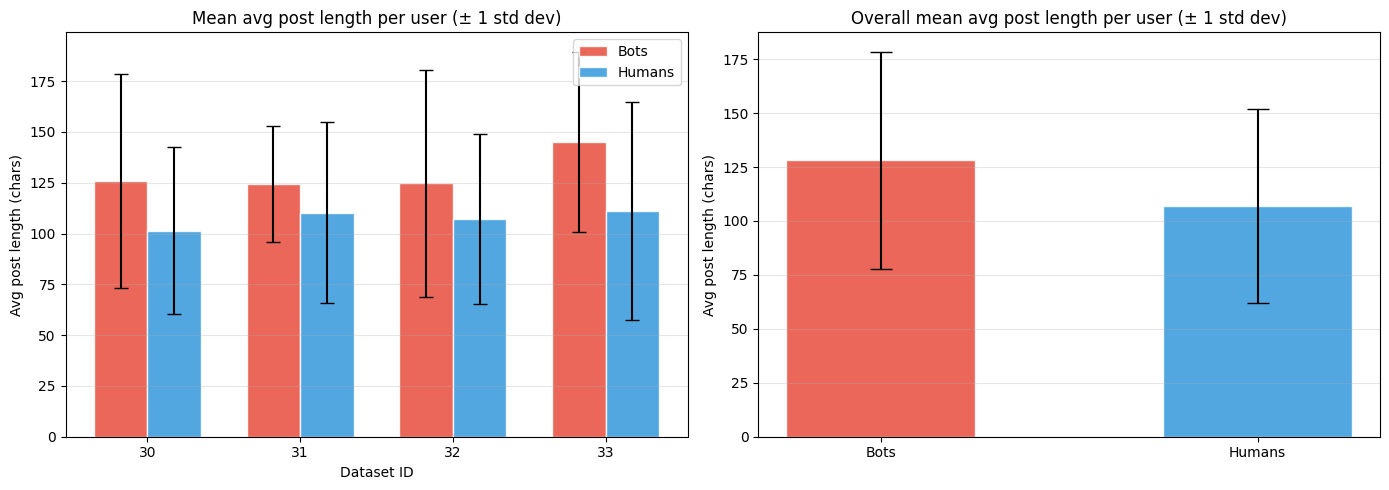

In [40]:
bot_len_arr = np.array([l for ls in bot_post_lengths.values() for l in ls], dtype=float)
human_len_arr = np.array([l for ls in human_post_lengths.values() for l in ls], dtype=float)

print(f"Bots   — mean avg post length: {bot_len_arr.mean():.1f} chars, std: {bot_len_arr.std():.1f}")
print(f"Humans — mean avg post length: {human_len_arr.mean():.1f} chars, std: {human_len_arr.std():.1f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: per-dataset mean avg-post-length with std dev ---
labels = [str(d) for d in dataset_ids]
x = np.arange(len(labels))
width = 0.35

bot_means_l = [np.mean(bot_post_lengths[d]) for d in dataset_ids]
bot_stds_l = [np.std(bot_post_lengths[d]) for d in dataset_ids]
human_means_l = [np.mean(human_post_lengths[d]) for d in dataset_ids]
human_stds_l = [np.std(human_post_lengths[d]) for d in dataset_ids]

axes[0].bar(x - width / 2, bot_means_l, width, yerr=bot_stds_l, label="Bots",
            capsize=5, color="#e74c3c", alpha=0.85, edgecolor="white")
axes[0].bar(x + width / 2, human_means_l, width, yerr=human_stds_l, label="Humans",
            capsize=5, color="#3498db", alpha=0.85, edgecolor="white")
axes[0].set_xlabel("Dataset ID")
axes[0].set_ylabel("Avg post length (chars)")
axes[0].set_title("Mean avg post length per user (± 1 std dev)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# --- Right: overall aggregated bar ---
categories = ["Bots", "Humans"]
means = [bot_len_arr.mean(), human_len_arr.mean()]
stds = [bot_len_arr.std(), human_len_arr.std()]
colors = ["#e74c3c", "#3498db"]

axes[1].bar(categories, means, yerr=stds, capsize=8, color=colors,
            alpha=0.85, edgecolor="white", width=0.5)
axes[1].set_ylabel("Avg post length (chars)")
axes[1].set_title("Overall mean avg post length per user (± 1 std dev)")
axes[1].grid(axis="y", alpha=0.3)

fig.tight_layout()
plt.show()

## Plot 6 — Histogram of individual post lengths

Bots   — total posts: 7014, mean length: 134.2, std: 128.6
Humans — total posts: 17755, mean length: 108.8, std: 73.8


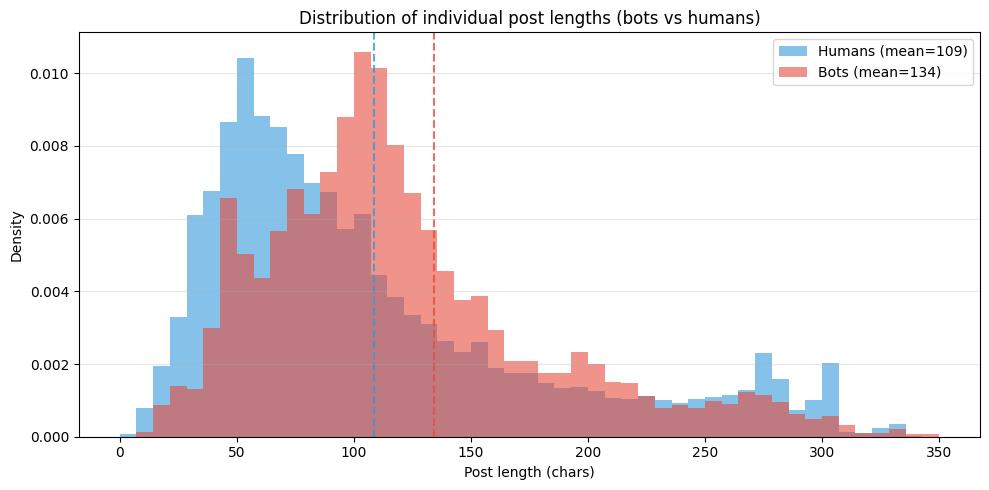

In [41]:
bot_posts_arr = np.array(bot_all_post_lens, dtype=float)
human_posts_arr = np.array(human_all_post_lens, dtype=float)

print(f"Bots   — total posts: {len(bot_posts_arr)}, mean length: {bot_posts_arr.mean():.1f}, std: {bot_posts_arr.std():.1f}")
print(f"Humans — total posts: {len(human_posts_arr)}, mean length: {human_posts_arr.mean():.1f}, std: {human_posts_arr.std():.1f}")

fig, ax = plt.subplots(figsize=(10, 5))

cap = 350  # cap x-axis for readability
bins = np.linspace(0, cap, 50)

ax.hist(human_posts_arr[human_posts_arr <= cap], bins=bins, alpha=0.6,
        label=f"Humans (mean={human_posts_arr.mean():.0f})", color="#3498db", density=True)
ax.hist(bot_posts_arr[bot_posts_arr <= cap], bins=bins, alpha=0.6,
        label=f"Bots (mean={bot_posts_arr.mean():.0f})", color="#e74c3c", density=True)

ax.axvline(bot_posts_arr.mean(), color="#e74c3c", linestyle="--", linewidth=1.5, alpha=0.8)
ax.axvline(human_posts_arr.mean(), color="#3498db", linestyle="--", linewidth=1.5, alpha=0.8)

ax.set_xlabel("Post length (chars)")
ax.set_ylabel("Density")
ax.set_title("Distribution of individual post lengths (bots vs humans)")
ax.legend()
ax.grid(axis="y", alpha=0.3)
fig.tight_layout()
plt.show()

## Plot 7 — @ mention frequency: bots vs humans

Bots   — mean @mentions/user: 4.07, std: 8.59
Humans — mean @mentions/user: 2.02, std: 7.16


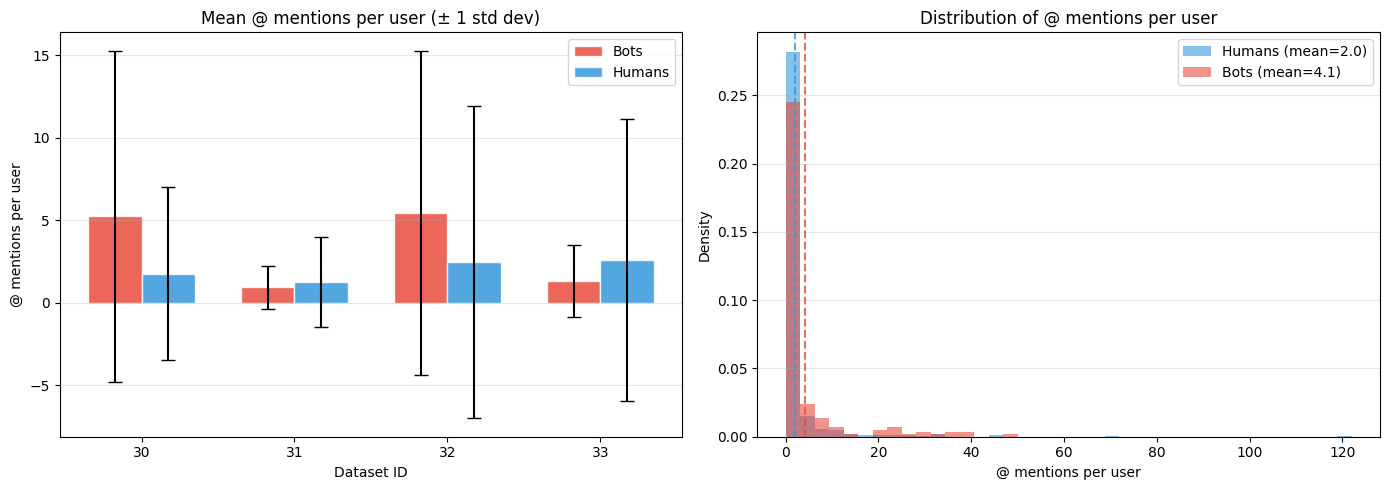

In [42]:
all_bot_ments = np.array([m for ms in bot_mention_counts.values() for m in ms], dtype=float)
all_human_ments = np.array([m for ms in human_mention_counts.values() for m in ms], dtype=float)

print(f"Bots   — mean @mentions/user: {all_bot_ments.mean():.2f}, std: {all_bot_ments.std():.2f}")
print(f"Humans — mean @mentions/user: {all_human_ments.mean():.2f}, std: {all_human_ments.std():.2f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: per-dataset bar chart with std dev ---
labels = [str(d) for d in dataset_ids]
x = np.arange(len(labels))
width = 0.35

bot_means_m = [np.mean(bot_mention_counts[d]) for d in dataset_ids]
bot_stds_m = [np.std(bot_mention_counts[d]) for d in dataset_ids]
human_means_m = [np.mean(human_mention_counts[d]) for d in dataset_ids]
human_stds_m = [np.std(human_mention_counts[d]) for d in dataset_ids]

axes[0].bar(x - width / 2, bot_means_m, width, yerr=bot_stds_m, label="Bots",
            capsize=5, color="#e74c3c", alpha=0.85, edgecolor="white")
axes[0].bar(x + width / 2, human_means_m, width, yerr=human_stds_m, label="Humans",
            capsize=5, color="#3498db", alpha=0.85, edgecolor="white")
axes[0].set_xlabel("Dataset ID")
axes[0].set_ylabel("@ mentions per user")
axes[0].set_title("Mean @ mentions per user (± 1 std dev)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# --- Right: histogram of per-user @ mention counts ---
max_val = int(max(all_bot_ments.max(), all_human_ments.max()))
bins = np.linspace(0, min(max_val, 150), 40)

axes[1].hist(all_human_ments, bins=bins, alpha=0.6, label=f"Humans (mean={all_human_ments.mean():.1f})",
             color="#3498db", density=True)
axes[1].hist(all_bot_ments, bins=bins, alpha=0.6, label=f"Bots (mean={all_bot_ments.mean():.1f})",
             color="#e74c3c", density=True)
axes[1].axvline(all_bot_ments.mean(), color="#e74c3c", linestyle="--", linewidth=1.5, alpha=0.8)
axes[1].axvline(all_human_ments.mean(), color="#3498db", linestyle="--", linewidth=1.5, alpha=0.8)
axes[1].set_xlabel("@ mentions per user")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of @ mentions per user")
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

fig.tight_layout()
plt.show()